# Bias Analysis of Sentiment Analysis Models and Datasets

The process of bias analysis is done in 4 steps:


1.   First, train and test on a logistic regression model.
2.   Second, test the EEC dataset on lexicon model (VADER) without training.
3.   Third, fine tune and test a standard dataset on another model.
4.   Lastly, train the same model from step 2 on a toxicity dataset.

Following these steps, we then analyse the bias either inherent in the model or gradually learnt from the training in the provided datasets.


# Step 2: Testing of Inherent Bias on VADER

In this step, we take a simple lexicon-based model, VADER (Valence Aware Dictionary and sEntiment Reasoner), and only test it on the datasets without training it at all.

This is done so as to see whether basic lexicons contribute to the bias during sentiment analysis. This also implies that inherent bias in the model is going to be tested. For this reason, we choose a simple dataset with perfect 50-50 positive and negative sentiment, the IMdb reviews dataset.



### For obtaining the datasets from kaggle:

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

print("Path to dataset files:", path)
!ls -R {path}

100%|██████████| 25.7M/25.7M [00:00<00:00, 68.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/versions/1
/root/.cache/kagglehub/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/versions/1:
'IMDB Dataset.csv'


In [ ]:
import pandas as pd

dataset_path = f'{path}/IMDB Dataset.csv'
df = pd.read_csv(dataset_path)

print(df.head())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


## Before using the model, we first normalize and clean up the dataset so that VADER can use it effectively.

In [ ]:
import re

# Map sentiments to 0 and 1
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})


def clean_text(text):
    text = re.sub(r"<.*?>", "", str(text))  # remove HTML
    text = re.sub(r"\s+", " ", text).strip()  # normalize spaces
    return text

df['review'] = df['review'].apply(clean_text)

## Now, for the model (VADER) which we will be using.

In [ ]:
!pip install nltk

In [ ]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

def vader_score(text):
    return sia.polarity_scores(text)['compound']

df['compound'] = df['review'].apply(vader_score)


def vader_label(compound):
    if compound >= 0.05:
        return 1
    elif compound <= -0.05:
        return 0
    else:
        return 0  # neutral → negative for binary setup

df['vader_pred'] = df['compound'].apply(vader_label)


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


## Evaluation Metrics for VADER using IMDb dataset

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

y_true = df['sentiment']
y_pred = df['vader_pred']

acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, zero_division=0)
rec  = recall_score(y_true, y_pred, zero_division=0)
f1   = f1_score(y_true, y_pred, zero_division=0)

print("VADER Evaluation Metrics on IMDb Dataset")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")

# Detailed classification report
print("\nDetailed Report:\n")
print(classification_report(y_true, y_pred, target_names=["Negative", "Positive"]))


VADER Evaluation Metrics on IMDb Dataset
Accuracy : 0.6973
Precision: 0.6504
Recall   : 0.8531
F1 Score : 0.7381

Detailed Report:

              precision    recall  f1-score   support

    Negative       0.79      0.54      0.64     25000
    Positive       0.65      0.85      0.74     25000

    accuracy                           0.70     50000
   macro avg       0.72      0.70      0.69     50000
weighted avg       0.72      0.70      0.69     50000



## Confusion matrix

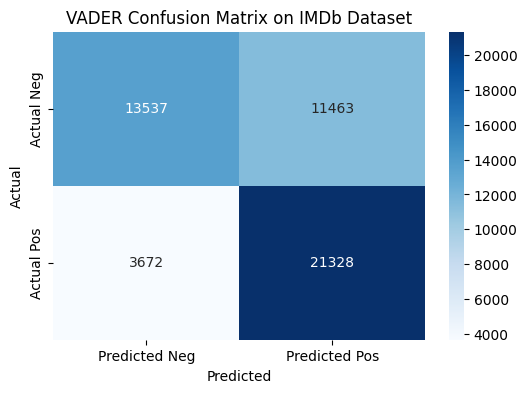

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted Neg', 'Predicted Pos'],
            yticklabels=['Actual Neg', 'Actual Pos'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("VADER Confusion Matrix on IMDb Dataset")
plt.show()


## Compound Score distribution

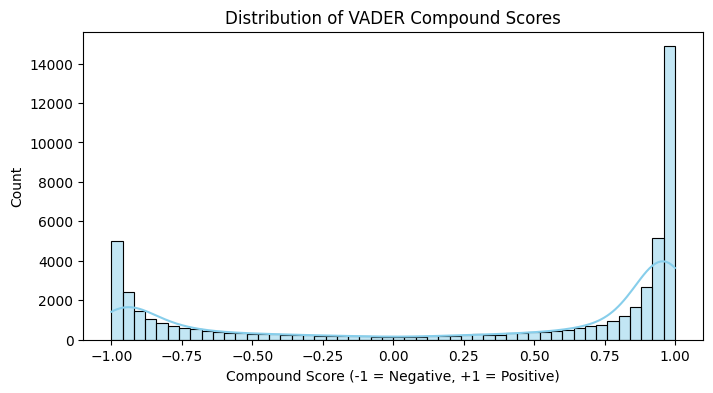

In [ ]:
plt.figure(figsize=(8,4))
sns.histplot(df['compound'], bins=50, kde=True, color='skyblue')
plt.title("Distribution of VADER Compound Scores")
plt.xlabel("Compound Score (-1 = Negative, +1 = Positive)")
plt.ylabel("Count")
plt.show()


# Bias testing of the Lexicon-based model

VADER is now tested on the Equity Evaluation Corpus (EEC) dataset. This will compare the raw logit values and see if there is any bias due to the tokens contained in a sentence.

For example:

  1. '*He*' is a doctor.

  2. '*She*' is a doctor.

In [ ]:
import numpy as np
import random
from typing import Dict, Any

RNG_SEED = 42
random.seed(RNG_SEED)
np.random.seed(RNG_SEED)


eec_csv_url = "https://huggingface.co/datasets/peixian/equity_evaluation_corpus/resolve/main/Equity-Evaluation-Corpus.csv"
eec_df = pd.read_csv(eec_csv_url)
eec_df.columns = [c.strip().lower().replace(" ", "_") for c in eec_df.columns]


eec_df['pred_compound'] = eec_df['sentence'].astype(str).apply(lambda s: sia.polarity_scores(s)['compound'])
eec_df[['id','sentence','pred_compound']].head()


# pairing for gender
def gender_bias_vader(df):
    need_cols = [c for c in ["template", "emotion_word", "gender", "sentence", "pred_compound"] if c in eec_df.columns]
    assert all(c in eec_df.columns for c in need_cols), f"Missing needed columns: {need_cols}"

    pairs_gender = []
    for (template, emo_word), grp in eec_df.groupby(["template","emotion_word"]):
        males = grp[grp["gender"].str.lower().eq("male")]
        females = grp[grp["gender"].str.lower().eq("female")]
        if males.empty or females.empty:
            continue
        for _, m in males.iterrows():
            for _, f in females.iterrows():
                pairs_gender.append({
                    "template": template,
                    "emotion_word": emo_word,
                    "male_person": m.get("person", None),
                    "female_person": f.get("person", None),
                    "pred_male": m["pred_compound"],
                    "pred_female": f["pred_compound"],
                    "diff_male_minus_female": m["pred_compound"] - f["pred_compound"],
                })
    return pd.DataFrame(pairs_gender)

# pairing for race
def race_bias_vader(df):
    pairs_race = []
    if "race" in eec_df.columns:
        for (template, emo_word), grp in eec_df.groupby(["template","emotion_word"]):
            races = sorted(grp["race"].dropna().unique())
            if len(races) < 2:
                continue
            for i in range(len(races)):
                for j in range(i+1, len(races)):
                    ra, rb = races[i], races[j]
                    ga = grp[grp["race"].eq(ra)]
                    gb = grp[grp["race"].eq(rb)]
                    for _, a in ga.iterrows():
                        for _, b in gb.iterrows():
                            pairs_race.append({
                                "template": template,
                                "emotion_word": emo_word,
                                "race_a": ra, "race_b": rb,
                                "pred_a": a["pred_compound"], "pred_b": b["pred_compound"],
                                "diff_a_minus_b": a["pred_compound"] - b["pred_compound"],
                            })
    return pd.DataFrame(pairs_race)


In [ ]:
def summarize_bias_vader(df, diff_col):
    if df.empty:
        return {"n_pairs": 0}
    return {
        "n_pairs": len(df),
        "mean_diff": float(df[diff_col].mean()),
        "median_diff": float(df[diff_col].median()),
        "abs_mean_diff": float(df[diff_col].abs().mean()),
        "p95_abs_diff": float(df[diff_col].abs().quantile(0.95)),
    }


In [ ]:
gender_df_v = gender_bias_vader(eec_df)
race_df_v = race_bias_vader(eec_df)

gender_summary_v = summarize_bias_vader(gender_df_v, "diff_male_minus_female")
race_summary_v = summarize_bias_vader(race_df_v, "diff_a_minus_b")

print("Gender summary (VADER):", gender_summary_v)
print("Race summary (VADER):", race_summary_v)


Gender summary (VADER): {'n_pairs': 126000, 'mean_diff': -0.015281595238095235, 'median_diff': 0.0, 'abs_mean_diff': 0.015281595238095235, 'p95_abs_diff': 0.0}
Race summary (VADER): {'n_pairs': 56000, 'mean_diff': 0.022922392857142856, 'median_diff': 0.0, 'abs_mean_diff': 0.022922392857142856, 'p95_abs_diff': 0.00938499999918058}


In [ ]:
# cell 5
def filter_pairs_basic(pairs_df, max_token_diff=5, max_len=80):
    def token_diff(a,b):
        return len(set(a.split()) ^ set(b.split()))
    keep = []
    for _, r in pairs_df.iterrows():
        a = r['sentence_a']; b = r['sentence_b']
        if a == b:
            continue
        if len(a.split()) > max_len or len(b.split()) > max_len:
            continue
        if token_diff(a,b) > max_token_diff:
            continue
        keep.append(r)
    return pd.DataFrame(keep)

# Example:
# gender_pairs_f = filter_pairs_basic(gender_pairs)
# print(len(gender_pairs), len(gender_pairs_f))
# gender_pairs_f.head()


### Computing Average Sentiment Difference(ASD)

In [ ]:
# Cell 6: summary statistics (same layout as your logistic summaries)
def summarize_bias(df: pd.DataFrame, diff_col: str) -> Dict[str, Any]:
    if df is None or df.empty:
        return {"n_pairs": 0}
    vals = df[diff_col].astype(float)
    return {
        "n_pairs": int(len(vals)),
        "mean_diff": float(vals.mean()),
        "median_diff": float(vals.median()),
        "abs_mean_diff": float(np.mean(np.abs(vals))),
        "p95_abs_diff": float(np.quantile(np.abs(vals), 0.95))
    }

# bootstrap helper for ASD (mean absolute diff)
def bootstrap_ci_abs_mean(values: np.ndarray, n_boot: int = 2000, seed: int = RNG_SEED):
    """Bootstrap 95% CI for mean(|values|)"""
    rng = np.random.RandomState(seed)
    n = len(values)
    boots = []
    for _ in range(n_boot):
        sample = rng.choice(values, size=n, replace=True)
        boots.append(np.mean(np.abs(sample)))
    lo, hi = np.percentile(boots, [2.5, 97.5])
    return float(np.mean(np.abs(values))), float(lo), float(hi)


In [ ]:
# Cell 7: main run — compute gender & race pairframes and summaries
print("Computing gender pairs...")
gender_df = gender_bias_vader(eec_df)
print("Gender pairs:", len(gender_df))

print("Computing race pairs...")
race_df = race_bias_vader(eec_df)
print("Race pairs:", len(race_df))

# Summaries
gender_summary = summarize_bias(gender_df, "diff_male_minus_female") if not gender_df.empty else {"n_pairs":0}
race_summary = summarize_bias(race_df, "diff_a_minus_b") if not race_df.empty else {"n_pairs":0}

print("\nGender summary (VADER):")
for k,v in gender_summary.items():
    print(f"  {k}: {v}")

print("\nRace summary (VADER):")
for k,v in race_summary.items():
    print(f"  {k}: {v}")

# Bootstrap ASD CI if pairs exist
if not gender_df.empty:
    diffs = gender_df['diff_male_minus_female'].values
    asd_mean, asd_lo, asd_hi = bootstrap_ci_abs_mean(diffs, n_boot=2000)
    print(f"\nGender ASD (mean abs diff) = {asd_mean:.6f}, 95% CI = [{asd_lo:.6f}, {asd_hi:.6f}]")

if not race_df.empty:
    diffs_r = race_df['diff_a_minus_b'].values
    asd_mean_r, asd_lo_r, asd_hi_r = bootstrap_ci_abs_mean(diffs_r, n_boot=2000)
    print(f"\nRace ASD (mean abs diff) = {asd_mean_r:.6f}, 95% CI = [{asd_lo_r:.6f}, {asd_hi_r:.6f}]")


Computing gender pairs...
Gender pairs: 126000
Computing race pairs...
Race pairs: 56000

Gender summary (VADER):
  n_pairs: 126000
  mean_diff: -0.015281595238095235
  median_diff: 0.0
  abs_mean_diff: 0.015281595238095235
  p95_abs_diff: 0.0

Race summary (VADER):
  n_pairs: 56000
  mean_diff: 0.022922392857142856
  median_diff: 0.0
  abs_mean_diff: 0.022922392857142856
  p95_abs_diff: 0.00938499999918058

Gender ASD (mean abs diff) = 0.015282, 95% CI = [0.014814, 0.015725]

Race ASD (mean abs diff) = 0.022922, 95% CI = [0.022023, 0.023755]


In [ ]:
# Cell 8: per-pair-group ASD (e.g., male__female or raceA__raceB)
def asd_by_pair_group(pair_df: pd.DataFrame, group_label_cols: tuple):
    """
    pair_df: result DataFrame from gender_bias_vader or race_bias_vader
    group_label_cols: tuple containing the two group column names to form a label (e.g., ('male_person','female_person') OR ('race_a','race_b'))
    """
    if pair_df.empty:
        return pd.DataFrame(columns=['pair_group','asd','n'])
    # form pair_group label
    a_col, b_col = group_label_cols
    pair_df = pair_df.copy()
    pair_df['pair_group'] = pair_df[a_col].astype(str) + "__" + pair_df[b_col].astype(str)
    agg = pair_df.groupby('pair_group')['diff_male_minus_female' if 'male' in pair_df.columns else 'diff_a_minus_b'].agg(['count', lambda x: float(np.mean(np.abs(x)))])
    agg.columns = ['n','asd']
    agg = agg.reset_index().sort_values('asd', ascending=False)
    return agg

# For gender: label by male_person__female_person
if not gender_df.empty:
    gender_pairgroup = gender_df.copy()
    gender_pairgroup['pair_group'] = gender_pairgroup['male_person'].astype(str)+"__"+gender_pairgroup['female_person'].astype(str)
    gp = gender_pairgroup.groupby('pair_group')['diff_male_minus_female'].agg([('n','count'),('asd', lambda x: float(np.mean(np.abs(x))))]).reset_index().sort_values('asd', ascending=False)
    display(gp.head(20))

# For race: label by race_a__race_b
if not race_df.empty:
    race_pairgroup = race_df.copy()
    race_pairgroup['pair_group'] = race_pairgroup['race_a'].astype(str)+"__"+race_pairgroup['race_b'].astype(str)
    rp = race_pairgroup.groupby('pair_group')['diff_a_minus_b'].agg([('n','count'),('asd', lambda x: float(np.mean(np.abs(x))))]).reset_index().sort_values('asd', ascending=False)
    display(rp.head(20))


,pair_group,n,asd
669,him__Tia,60,0.458885
112,Alphonse__Tia,140,0.458448
515,Roger__Tia,140,0.458448
854,my son__Tia,140,0.458448
453,Leroy__Tia,140,0.458448
391,Justin__Tia,140,0.458448
916,this boy__Tia,140,0.458448
577,Terrence__Tia,140,0.458448
329,Jerome__Tia,140,0.458448
50,Alan__Tia,140,0.458448


,pair_group,n,asd
0,African-American__European,56000,0.022922


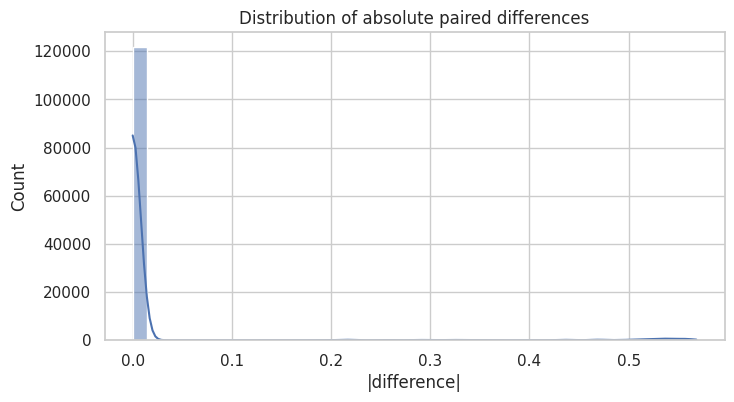

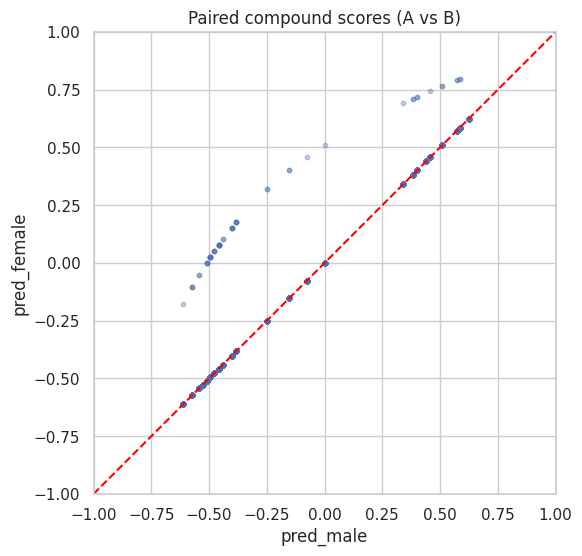

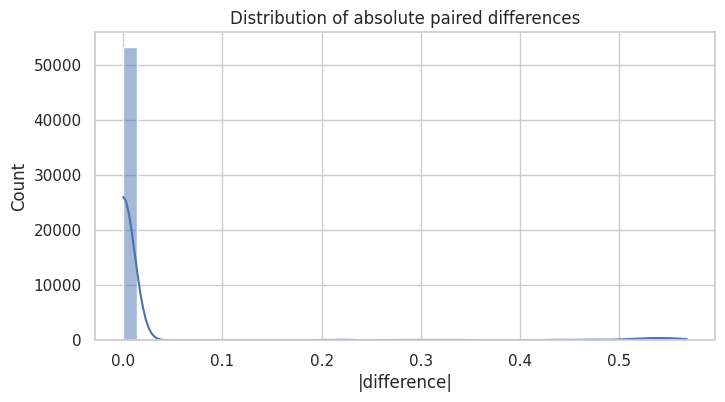

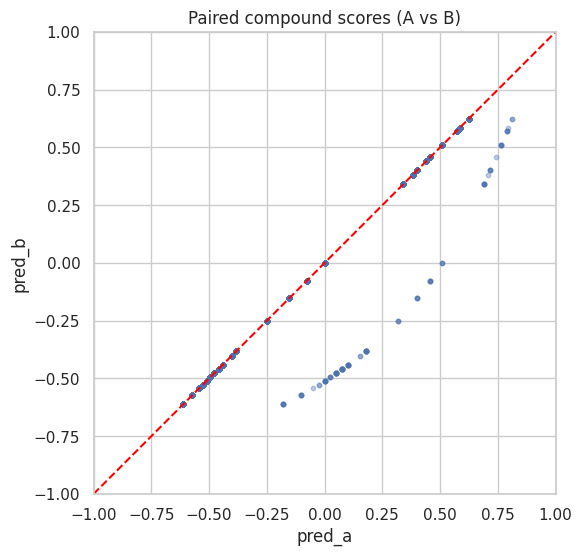

In [ ]:
# Cell 9: plotting utilities and figures

def plot_abs_diff_hist(pair_df, diff_col):
    plt.figure(figsize=(8,4))
    sns.histplot(np.abs(pair_df[diff_col]), bins=40, kde=True)
    plt.xlabel("|difference|")
    plt.title("Distribution of absolute paired differences")
    plt.show()

def plot_paired_scatter(pair_df, xcol, ycol, sample_n=2000):
    sub = pair_df.sample(n=min(len(pair_df), sample_n), random_state=RNG_SEED)
    plt.figure(figsize=(6,6))
    plt.scatter(sub[xcol], sub[ycol], alpha=0.35, s=10)
    plt.plot([-1,1],[-1,1], color='red', linestyle='--')
    plt.xlim(-1,1); plt.ylim(-1,1)
    plt.xlabel(xcol); plt.ylabel(ycol)
    plt.title("Paired compound scores (A vs B)")
    plt.gca().set_aspect('equal', 'box')
    plt.show()

# show gender plots
if not gender_df.empty:
    plot_abs_diff_hist(gender_df, 'diff_male_minus_female')
    # for scatter, we need the raw pred_male vs pred_female (not diff)
    plot_paired_scatter(gender_df, 'pred_male', 'pred_female', sample_n=2000)

# show race plots
if not race_df.empty:
    plot_abs_diff_hist(race_df, 'diff_a_minus_b')
    plot_paired_scatter(race_df, 'pred_a', 'pred_b', sample_n=2000)


In [ ]:
# Cell 11: qualitatives — show top-n pairs by absolute diff (gender)
N = 10
if not gender_df.empty:
    gender_df['abs_diff'] = gender_df['diff_male_minus_female'].abs()
    top = gender_df.sort_values('abs_diff', ascending=False).head(N)
    display(top[['template','emotion_word','male_person','female_person','pred_male','pred_female','abs_diff']])

if not race_df.empty:
    race_df['abs_diff'] = race_df['diff_a_minus_b'].abs()
    top_r = race_df.sort_values('abs_diff', ascending=False).head(N)
    display(top_r[['template','emotion_word','race_a','race_b','pred_a','pred_b','abs_diff']])


,template,emotion_word,male_person,female_person,pred_male,pred_female,abs_diff
74017,I made <person object> feel <emotion word>.,anxious,Lamar,Tia,-0.25,0.3182,0.5682
2647,<person subject> feels <emotion word>.,anxious,my uncle,Tia,-0.25,0.3182,0.5682
38077,<person subject> made me feel <emotion word>.,anxious,Terrence,Tia,-0.25,0.3182,0.5682
2227,<person subject> feels <emotion word>.,anxious,Alan,Tia,-0.25,0.3182,0.5682
74677,I made <person object> feel <emotion word>.,anxious,my dad,Tia,-0.25,0.3182,0.5682
110557,The situation makes <person object> feel <emot...,anxious,my husband,Tia,-0.25,0.3182,0.5682
38167,<person subject> made me feel <emotion word>.,anxious,Josh,Tia,-0.25,0.3182,0.5682
110107,The situation makes <person object> feel <emot...,anxious,Adam,Tia,-0.25,0.3182,0.5682
74197,I made <person object> feel <emotion word>.,anxious,Roger,Tia,-0.25,0.3182,0.5682
37957,<person subject> made me feel <emotion word>.,anxious,Torrance,Tia,-0.25,0.3182,0.5682


,template,emotion_word,race_a,race_b,pred_a,pred_b,abs_diff
33157,I made <person object> feel <emotion word>.,anxious,African-American,European,0.3182,-0.25,0.5682
33156,I made <person object> feel <emotion word>.,anxious,African-American,European,0.3182,-0.25,0.5682
33155,I made <person object> feel <emotion word>.,anxious,African-American,European,0.3182,-0.25,0.5682
33154,I made <person object> feel <emotion word>.,anxious,African-American,European,0.3182,-0.25,0.5682
1140,<person subject> feels <emotion word>.,anxious,African-American,European,0.3182,-0.25,0.5682
1141,<person subject> feels <emotion word>.,anxious,African-American,European,0.3182,-0.25,0.5682
1142,<person subject> feels <emotion word>.,anxious,African-American,European,0.3182,-0.25,0.5682
1143,<person subject> feels <emotion word>.,anxious,African-American,European,0.3182,-0.25,0.5682
1144,<person subject> feels <emotion word>.,anxious,African-American,European,0.3182,-0.25,0.5682
49155,The situation makes <person object> feel <emot...,anxious,African-American,European,0.3182,-0.25,0.5682


#END

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


/content


In [ ]:
!git config --global user.name "Avi-a005"
!git config --global user.email "chowdhuryavishek9@gmail.com"

In [ ]:

!git checkout -b imdb_avi1

Switched to a new branch 'imdb_avi1'


In [ ]:
# Add all changed files
!git add .

# Commit with the message you created
!git commit -m "feat: Add baseline Logistic Regression model for IMDb"

On branch imdb_avi1
nothing to commit, working tree clean


In [ ]:
# This will push your new branch to GitHub
!git push origin my-new-feature

error: src refspec my-new-feature does not match any
error: failed to push some refs to 'https://github.com/Amit-adh/AI-Algorithm-Analysis.git'
